In [1]:
import os
import sys

os.chdir('..')

In [2]:
# pyproj를 이용해 원하는 crs로 reprojection (transform)한 뒤, buffer를 생성하는 작업은 
# geopandas를 이용해 동일하게 구현할 수 있음.

'''import pyproj as proj
from pyproj import Transformer
from shapely.geometry import Point, MultiPoint

# setup your projections
#crs_from = proj.Proj(init='epsg:4326')
#crs_to = proj.Proj(init='epsg:5179') # use a locally appropriate projected CRS

crs_transformer = Transformer.from_crs(4326, 5179, always_xy=True)

# exclusion buffer 생성
p_latlon_points = [(34.633986, 127.46669399999999), (34.643878, 127.388011)]
p_xy_points = [(long, lat) for lat, long in p_latlon_points]

p_points = []
for x, y in crs_transformer.itransform(p_xy_points):
    p_points.append((x, y))
p_points = MultiPoint(p_points)

exclusion_dist = 1.0
circle_buffers = p_points.buffer(exclusion_dist)
print(p_points, '\n')
print(circle_buffers, '\n')
#print(circle_buffers.area, '\n')

# query points가 buffer 내에 존재하는지
query_latlon_points = [(34.633986, 127.47)]
query_xy_points = [(long, lat) for lat, long in query_latlon_points]
query_points = []
for x, y in crs_transformer.itransform(query_xy_points):
    query_points.append((x, y))
query_points = MultiPoint(query_points)

print(circle_buffers.contains(query_points))
'''
print()

In [3]:
import pandas as pd
import numpy as np

from lib.raster import PatchExtractor
from lib.dataset import EnvironmentalDataset
from lib.utils import set_reproducibility

random_seed = 42
set_reproducibility(random_seed=random_seed)

#SRC_DATASET_PATH = './data/full_dataset_CA.csv'
#TRG_DATASET_PATH = './data/full_dataset_KR.csv'
#SRC_RASTER_PATH = './data/rasters_CA/'
#TRG_RASTER_PATH = './data/rasters_KR/'

SRC_DATASET_PATH = './data/Micromys minutus_멧밭쥐_GB,KR_no_redundancy.csv'
TRG_DATASET_PATH = './data/Micromys minutus_멧밭쥐_GB,KR_no_redundancy.csv'
SRC_RASTER_PATH = './data/rasters_GB/'
TRG_RASTER_PATH = './data/rasters_KR/'

# csv columns
LATITUDE = 'decimalLatitude'
LONGITUDE = 'decimalLongitude'

# environmental patches
PATCH_SIZE = 1

# create patch extractor and add all default rasters
src_extractor = PatchExtractor(SRC_RASTER_PATH, size=PATCH_SIZE, verbose=True)
src_extractor.add_all(normalized=True, transform=None, ignore=[])

trg_extractor = PatchExtractor(TRG_RASTER_PATH, size=PATCH_SIZE, verbose=True)
trg_extractor.add_all(normalized=True, transform=None, ignore=[])

# READ DATASET
src_df = pd.read_csv(SRC_DATASET_PATH, header='infer', sep=',', low_memory=False)
trg_df = pd.read_csv(TRG_DATASET_PATH, header='infer', sep=',', low_memory=False)
src_df = src_df[src_df['countryCode'] == 'GB']
trg_df = trg_df[trg_df['countryCode'] == 'KR']

# presence positions
src_p_pos = src_df[[LATITUDE, LONGITUDE]].to_numpy()
trg_p_pos = trg_df[[LATITUDE, LONGITUDE]].to_numpy()

# presence labels
src_p_labels = np.ones(len(src_p_pos), dtype=np.float32)
trg_p_labels = np.ones(len(trg_p_pos), dtype=np.float32)

# To train presence/absence model, sampling pseudo-absence points from valid positions
# Valid positions are determined by a raster (study area) and presence positions
src_pa_pos = src_extractor.get_valid_positions(raster_name='bioclim_1', \
                                                presence_pos=src_p_pos, sample_size=8000, drop_nodata=True, exclusion_dist=0)

trg_pa_pos = trg_extractor.get_valid_positions(raster_name='bioclim_1', \
                                                presence_pos=trg_p_pos, sample_size=8000, drop_nodata=True, exclusion_dist=0)

## TODO under sampling to fit imbalanced presence/absence samples
src_pa_pos = src_pa_pos[:len(src_p_pos)]
trg_pa_pos = trg_pa_pos[:len(trg_p_pos)]

# pseudo-absence ids, pos, labels
src_pa_labels = np.zeros(len(src_pa_pos), dtype=np.float32)
trg_pa_labels = np.zeros(len(trg_pa_pos), dtype=np.float32)

# merge presences and pseudo-absences
src_pos = np.concatenate((src_p_pos, src_pa_pos), axis=0)
src_labels = np.concatenate((src_p_labels, src_pa_labels), axis=0)
src_ids = np.arange(len(src_pos))

trg_pos = np.concatenate((trg_p_pos, trg_pa_pos), axis=0)
trg_labels = np.concatenate((trg_p_labels, trg_pa_labels), axis=0)
trg_ids = np.arange(len(trg_pos))

print(src_labels.shape, src_pos.shape)
print(trg_labels.shape, trg_pos.shape)

Adding ratser: bioclim_1  8.835687 1.216185 0.07916665

Adding ratser: bioclim_2  6.770873 0.8196168 0.45000005

Adding ratser: bioclim_3  38.11042 2.0615158 23.940859

Adding ratser: bioclim_4  415.37552 43.793545 222.73216

Adding ratser: bioclim_5  18.885485 1.8870498 9.5

Adding ratser: bioclim_6  1.1163571 1.2879353 -6.6

Adding ratser: bioclim_7  17.76913 2.0031872 7.200001

Adding ratser: bioclim_8  5.85202 2.0284302 -3.4166665

Adding ratser: bioclim_9  9.537036 2.6319342 1.9666665

Adding ratser: bioclim_10  14.152851 1.3859841 5.5666666

Adding ratser: bioclim_11  4.1383023 1.2673439 -4.1666665

Adding ratser: bioclim_12  1130.4138 456.82153 493.0

Adding ratser: bioclim_13  126.98602 58.249474 47.0

Adding ratser: bioclim_14  63.466404 20.435148 26.0

Adding ratser: bioclim_15  22.299395 6.531988 6.7239513

Adding ratser: bioclim_16  366.75095 168.05037 138.0

Adding ratser: bioclim_17  203.54686 62.065834 92.0

Adding ratser: bioclim_18  234.53809 73.7397 125.0

Adding rats

In [4]:
import numpy as np
import rasterio
import rasterio.plot as rplt
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point

src_r = rasterio.open('./data/rasters_KR/globcover/globcover.tif')
trg_r = rasterio.open('./data/rasters_KR/globcover/globcover.tif')

# circle buffer의 생성 지점인 presence points
#p_latlon_points = [(34.633986, 127.46669399999999), (34.643878, 127.388011)]
p_latlon_points = trg_pos[trg_labels == 1]
p_xy_points = [Point(long, lat) for lat, long in p_latlon_points]
#print(p_xy_points)

#query_latlon_points = [(34.633986, 127.45), (34.643878, 127.388011), (34.643878, 128.388011)]
query_latlon_points = trg_pos[trg_labels == 0]
q_xy_points = [Point(long, lat) for lat, long in query_latlon_points]
#print(q_xy_points)

p_gdf = gpd.GeoDataFrame(geometry=p_xy_points, crs=trg_r.crs)
q_gdf = gpd.GeoDataFrame(geometry=q_xy_points, crs=trg_r.crs)

#print(p_gdf)
print(q_gdf.to_crs(5181))

# 거리를 계산하기 적합한 crs로 reprojetion 후 buffer 생성
exclusion_dist = 10000 # crs 5181 (카카오맵)은 미터 단위
buffer_geometries = gpd.GeoSeries(p_xy_points, crs=trg_r.crs).to_crs(5181).buffer(exclusion_dist)
circle_buffers = gpd.GeoDataFrame(geometry=buffer_geometries)
print(circle_buffers)

#out_of_buffers_idx = (circle_buffers.contains(q_gdf.to_crs(5181), align=False) == False).to_numpy() # 1대1 매칭밖에 안되서 사용못함.
within = gpd.sjoin(q_gdf.to_crs(5181), circle_buffers, predicate='within', how='left')
# overlap되는 점들은 circle buffer의 인덱스를 의미하는 'index_right' 값이 존재한다 (여러 점들이 같은 circle안에 존재할 것).
# 반대로, overlap되지 않는 점들은 (목표) circle의 index_right이 NaN이며, 1개씩만 존재하게 됨.
out_of_circles = within[within['index_right'].isna()]
print(within)
print(out_of_circles)
print(out_of_circles.index.to_numpy())

                          geometry
0    POINT (172461.675 116289.917)
1    POINT (302610.619 369284.510)
2    POINT (301020.419 499699.122)
3    POINT (235502.706 230959.343)
4    POINT (231218.618 371498.904)
..                             ...
592  POINT (262380.760 167308.253)
593  POINT (264607.212 475279.547)
594  POINT (212416.135 517584.163)
595  POINT (277536.143 427290.547)
596  POINT (215334.088 519439.147)

[597 rows x 1 columns]
                                              geometry
0    POLYGON ((193674.062 -5931.735, 193625.909 -69...
1    POLYGON ((200143.021 452693.879, 200094.868 45...
2    POLYGON ((207780.803 364910.008, 207732.650 36...
3    POLYGON ((233791.618 322824.612, 233743.465 32...
4    POLYGON ((139011.315 -21554.124, 138963.163 -2...
..                                                 ...
592  POLYGON ((160200.072 360854.917, 160151.919 35...
593  POLYGON ((311155.949 440611.287, 311107.796 43...
594  POLYGON ((299221.562 277683.757, 299173.410 27...
595  P

<AxesSubplot:>

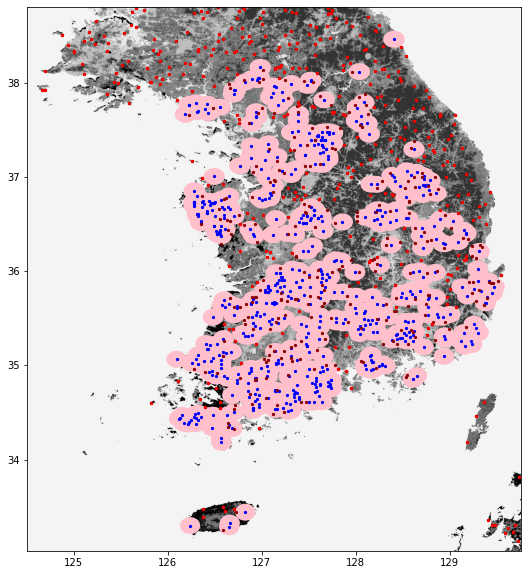

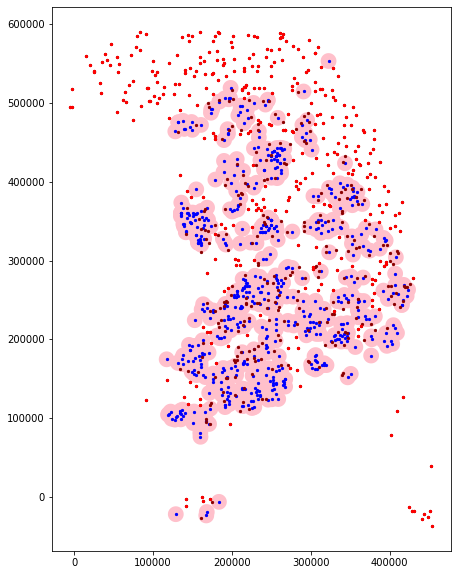

In [5]:
# plotting
fig1, ax1 = plt.subplots(figsize=(10,10))
circle_buffers.to_crs(4326).plot(ax=ax1, color='pink')
p_gdf.plot(ax=ax1, legend=True, markersize=5, color='blue')
q_gdf.plot(ax=ax1, legend=True, markersize=5, color='darkred')
out_of_circles.to_crs(4326).plot(ax=ax1, legend=True, markersize=5, color='r')
rplt.show(src_r, ax=ax1, cmap='Greys_r')

# plotting
fig2, ax2 = plt.subplots(figsize=(10,10))
circle_buffers.plot(ax=ax2, color='pink')
p_gdf.to_crs(5181).plot(ax=ax2, legend=True, markersize=5, color='blue')
q_gdf.to_crs(5181).plot(ax=ax2, legend=True, markersize=5, color='darkred')
out_of_circles.plot(ax=ax2, legend=True, markersize=5, color='r')